# Comparação dos Modelos de Análise de Sentimento

Este notebook compara os resultados de 3 modelos de análise de sentimento:
1. **bert-base-multilingual-uncased-sentiment** (nlptown)
2. **bertweet-base-sentiment-analysis** (finiteautomata)
3. **tabularisai-multilingual-sentiment**

**Análise inclui:**
- 📝 Títulos das PRs
- 📄 Descrições (Body)
- 💬 **Comentários** (issue comments, review comments, review bodies)

In [9]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from scipy import stats

# Configuração de visualização
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## 1. Carregamento dos Dados

In [10]:
# Caminhos dos arquivos
models_dir = Path('models')

paths = {
    'bert-multilingual': models_dir / 'bert-base-multilingual-uncased-sentiment' / 'prs_with_sentiments.json',
    'bertweet': models_dir / 'bertweet_base_sentiment_analysis' / 'prs_with_sentiments.json',
    'tabularisai': models_dir / 'tabularisai_multilingual_sentiment' / 'prs_with_sentiments.json'
}

# Carregar os dados
data = {}
for model_name, path in paths.items():
    with open(path, 'r', encoding='utf-8') as f:
        data[model_name] = json.load(f)
    print(f"{model_name}: {data[model_name]['total_prs']} PRs")

bert-multilingual: 100 PRs
bertweet: 100 PRs
tabularisai: 100 PRs


## 2. Processamento dos Dados

Extraímos sentimentos de **títulos, body E comentários**.

In [11]:
def get_dominant_sentiment(sentiment_list):
    """Retorna o sentimento com maior score"""
    if not sentiment_list:
        return None, 0.0
    max_item = max(sentiment_list, key=lambda x: x['score'])
    return max_item['label'], max_item['score']

def sentiment_to_numeric(label):
    """Converte label de sentimento para valor numérico"""
    if not label:
        return None

    label_str = str(label).lower().strip()

    # Verificar se é formato "X star" ou "X stars"
    if 'star' in label_str:
        try:
            return int(label_str.split()[0])
        except (ValueError, IndexError):
            return None

    # Mapeamento incluindo maiúsculas e minúsculas
    mapping = {
        'very positive': 5,
        'positive': 4,
        'neutral': 3,
        'negative': 2,
        'very negative': 1,
        'pos': 5,
        'neu': 3,
        'neg': 1
    }

    return mapping.get(label_str, None)

# Processar dados (INCLUINDO COMENTÁRIOS)
dfs = {}
comments_data = {}  # Armazenar comentários separadamente

for model_name, model_data in data.items():
    records = []
    all_comments = []  # Todos os comentários

    for pr in model_data['pull_requests']:
        title_label, title_score = get_dominant_sentiment(pr.get('title_sentiment', []))
        body_label, body_score = get_dominant_sentiment(pr.get('body_sentiment', []))
        created_at = pd.to_datetime(pr['created_at']) if pr.get('created_at') else None
        merged_at = pd.to_datetime(pr['merged_at']) if pr.get('merged_at') else None

        # Processar comentários
        pr_comments = []
        for comment in pr.get('comments', []):
            comment_label, comment_score = get_dominant_sentiment(comment.get('sentiment', []))
            if comment_label:  # Só adicionar se tiver sentiment
                comment_numeric = sentiment_to_numeric(comment_label)
                if comment_numeric is not None:  # Só adicionar se conversão foi bem-sucedida
                    pr_comments.append(comment_numeric)

                    comment_date = comment.get('created_at')
                    parsed_date = pd.to_datetime(comment_date, errors='coerce', utc=True) if comment_date else None

                    all_comments.append({
                        'pr_number': pr['number'],
                        'comment_type': comment.get('type', 'unknown'),
                        'author': comment.get('author'),
                        'sentiment_numeric': comment_numeric,
                        'sentiment_label': comment_label,
                        'sentiment_score': comment_score,
                        'created_at': parsed_date
                    })

        # Média dos comentários para esta PR
        avg_comment_sentiment = np.mean(pr_comments) if pr_comments else None

        records.append({
            'pr_number': pr['number'],
            'title': pr['title'],
            'created_at': created_at,
            'merged_at': merged_at,
            'title_sentiment_numeric': sentiment_to_numeric(title_label) if title_label else None,
            'title_sentiment_label': title_label,
            'title_sentiment_score': title_score,
            'body_sentiment_numeric': sentiment_to_numeric(body_label) if body_label else None,
            'body_sentiment_label': body_label,
            'body_sentiment_score': body_score,
            'comments_sentiment_avg': avg_comment_sentiment,
            'total_comments': len(pr_comments)
        })

    dfs[model_name] = pd.DataFrame(records)
    dfs[model_name]['date'] = dfs[model_name]['merged_at'].fillna(dfs[model_name]['created_at'])
    dfs[model_name] = dfs[model_name].sort_values('date')

    comments_data[model_name] = pd.DataFrame(all_comments)

print("\n✅ Dados processados!")
print(f"Período: {dfs['bert-multilingual']['date'].min()} até {dfs['bert-multilingual']['date'].max()}")
print(f"\n💬 Comentários analisados:")
for model_name in dfs.keys():
    print(f"  {model_name}: {len(comments_data[model_name])} comentários")


✅ Dados processados!
Período: 2023-09-18 23:41:53+00:00 até 2025-11-03 21:36:50+00:00

💬 Comentários analisados:
  bert-multilingual: 118 comentários
  bertweet: 111 comentários
  tabularisai: 118 comentários


## 3. Estatísticas Descritivas

In [12]:
print("=" * 80)
print("ESTATÍSTICAS DE SENTIMENTO")
print("=" * 80)

for model_name, df in dfs.items():
    print(f"\n{model_name.upper()}:")
    print(f"  📝 Títulos:")
    print(f"     Média: {df['title_sentiment_numeric'].mean():.2f} | Desvio: {df['title_sentiment_numeric'].std():.2f}")
    print(f"  📄 Body:")
    print(f"     Média: {df['body_sentiment_numeric'].mean():.2f} | Desvio: {df['body_sentiment_numeric'].std():.2f}")
    print(f"  💬 Comentários:")
    print(f"     Média: {df['comments_sentiment_avg'].mean():.2f} | Desvio: {df['comments_sentiment_avg'].std():.2f}")
    print(f"\n  PRs com comentários: {(df['total_comments'] > 0).sum()}/{len(df)}")
    print(f"  Total de comentários: {len(comments_data[model_name])}")

ESTATÍSTICAS DE SENTIMENTO

BERT-MULTILINGUAL:
  📝 Títulos:
     Média: 3.50 | Desvio: 1.38
  📄 Body:
     Média: 2.20 | Desvio: 1.43
  💬 Comentários:
     Média: 4.25 | Desvio: 1.09

  PRs com comentários: 67/100
  Total de comentários: 118

BERTWEET:
  📝 Títulos:
     Média: 2.84 | Desvio: 0.61
  📄 Body:
     Média: 3.09 | Desvio: 0.94
  💬 Comentários:
     Média: 4.32 | Desvio: 1.02

  PRs com comentários: 66/100
  Total de comentários: 111

TABULARISAI:
  📝 Títulos:
     Média: 2.75 | Desvio: 1.07
  📄 Body:
     Média: 2.24 | Desvio: 1.14
  💬 Comentários:
     Média: 3.58 | Desvio: 1.05

  PRs com comentários: 67/100
  Total de comentários: 118


## 4. Visualizações Comparativas

### 4.1. Títulos vs Body vs Comentários

/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_6836/3031888110.py:24: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_6836/3031888110.py:24: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_6836/3031888110.py:24: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from fon

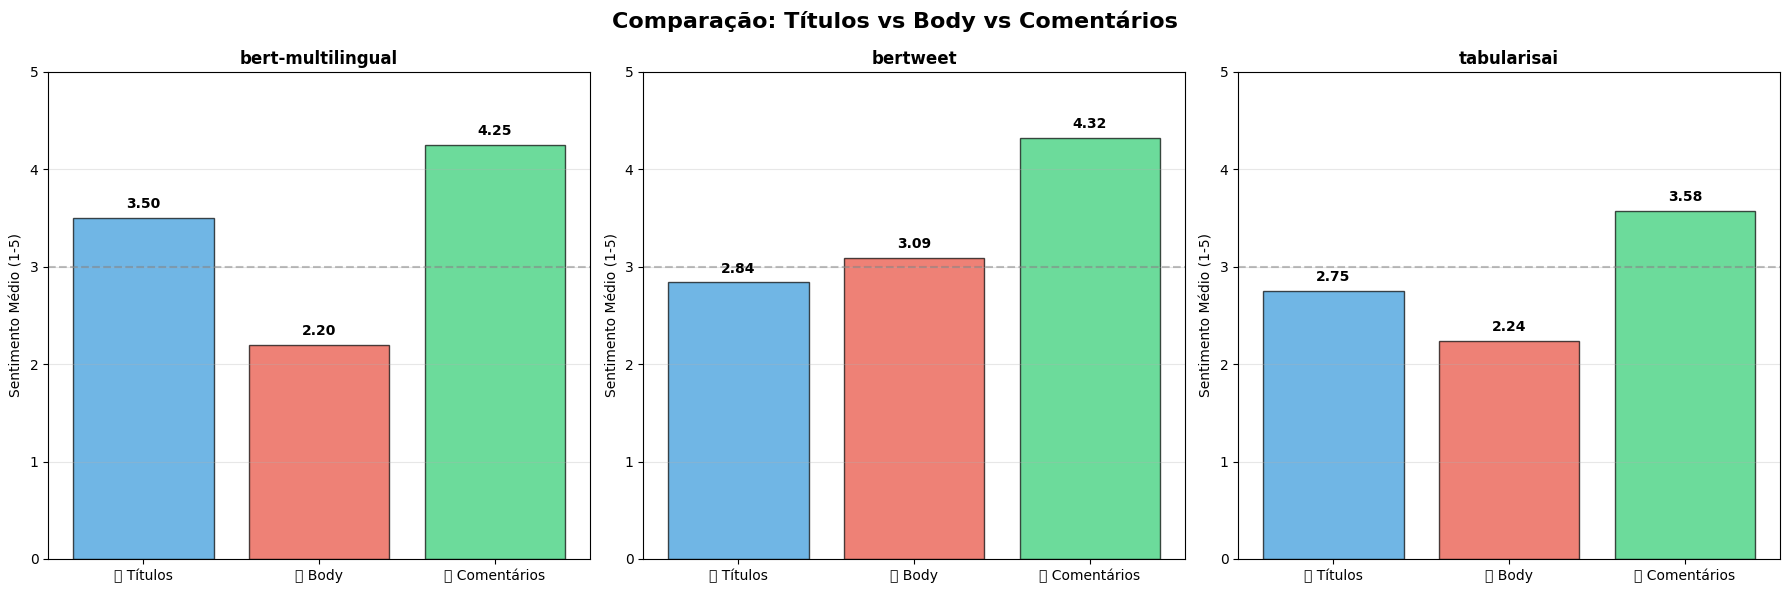

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparação: Títulos vs Body vs Comentários', fontsize=16, fontweight='bold')

for idx, (model_name, df) in enumerate(dfs.items()):
    categories = ['📝 Títulos', '📄 Body', '💬 Comentários']
    values = [
        df['title_sentiment_numeric'].mean(),
        df['body_sentiment_numeric'].mean(),
        df['comments_sentiment_avg'].mean()
    ]
    colors = ['#3498db', '#e74c3c', '#2ecc71']

    axes[idx].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
    axes[idx].set_title(model_name, fontweight='bold')
    axes[idx].set_ylabel('Sentimento Médio (1-5)')
    axes[idx].set_ylim([0, 5])
    axes[idx].axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Neutro')
    axes[idx].grid(axis='y', alpha=0.3)

    # Adicionar valores
    for i, v in enumerate(values):
        axes[idx].text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 4.2. Distribuições de Sentimento

/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_6836/2937789136.py:28: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_6836/2937789136.py:28: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_6836/2937789136.py:28: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from fon

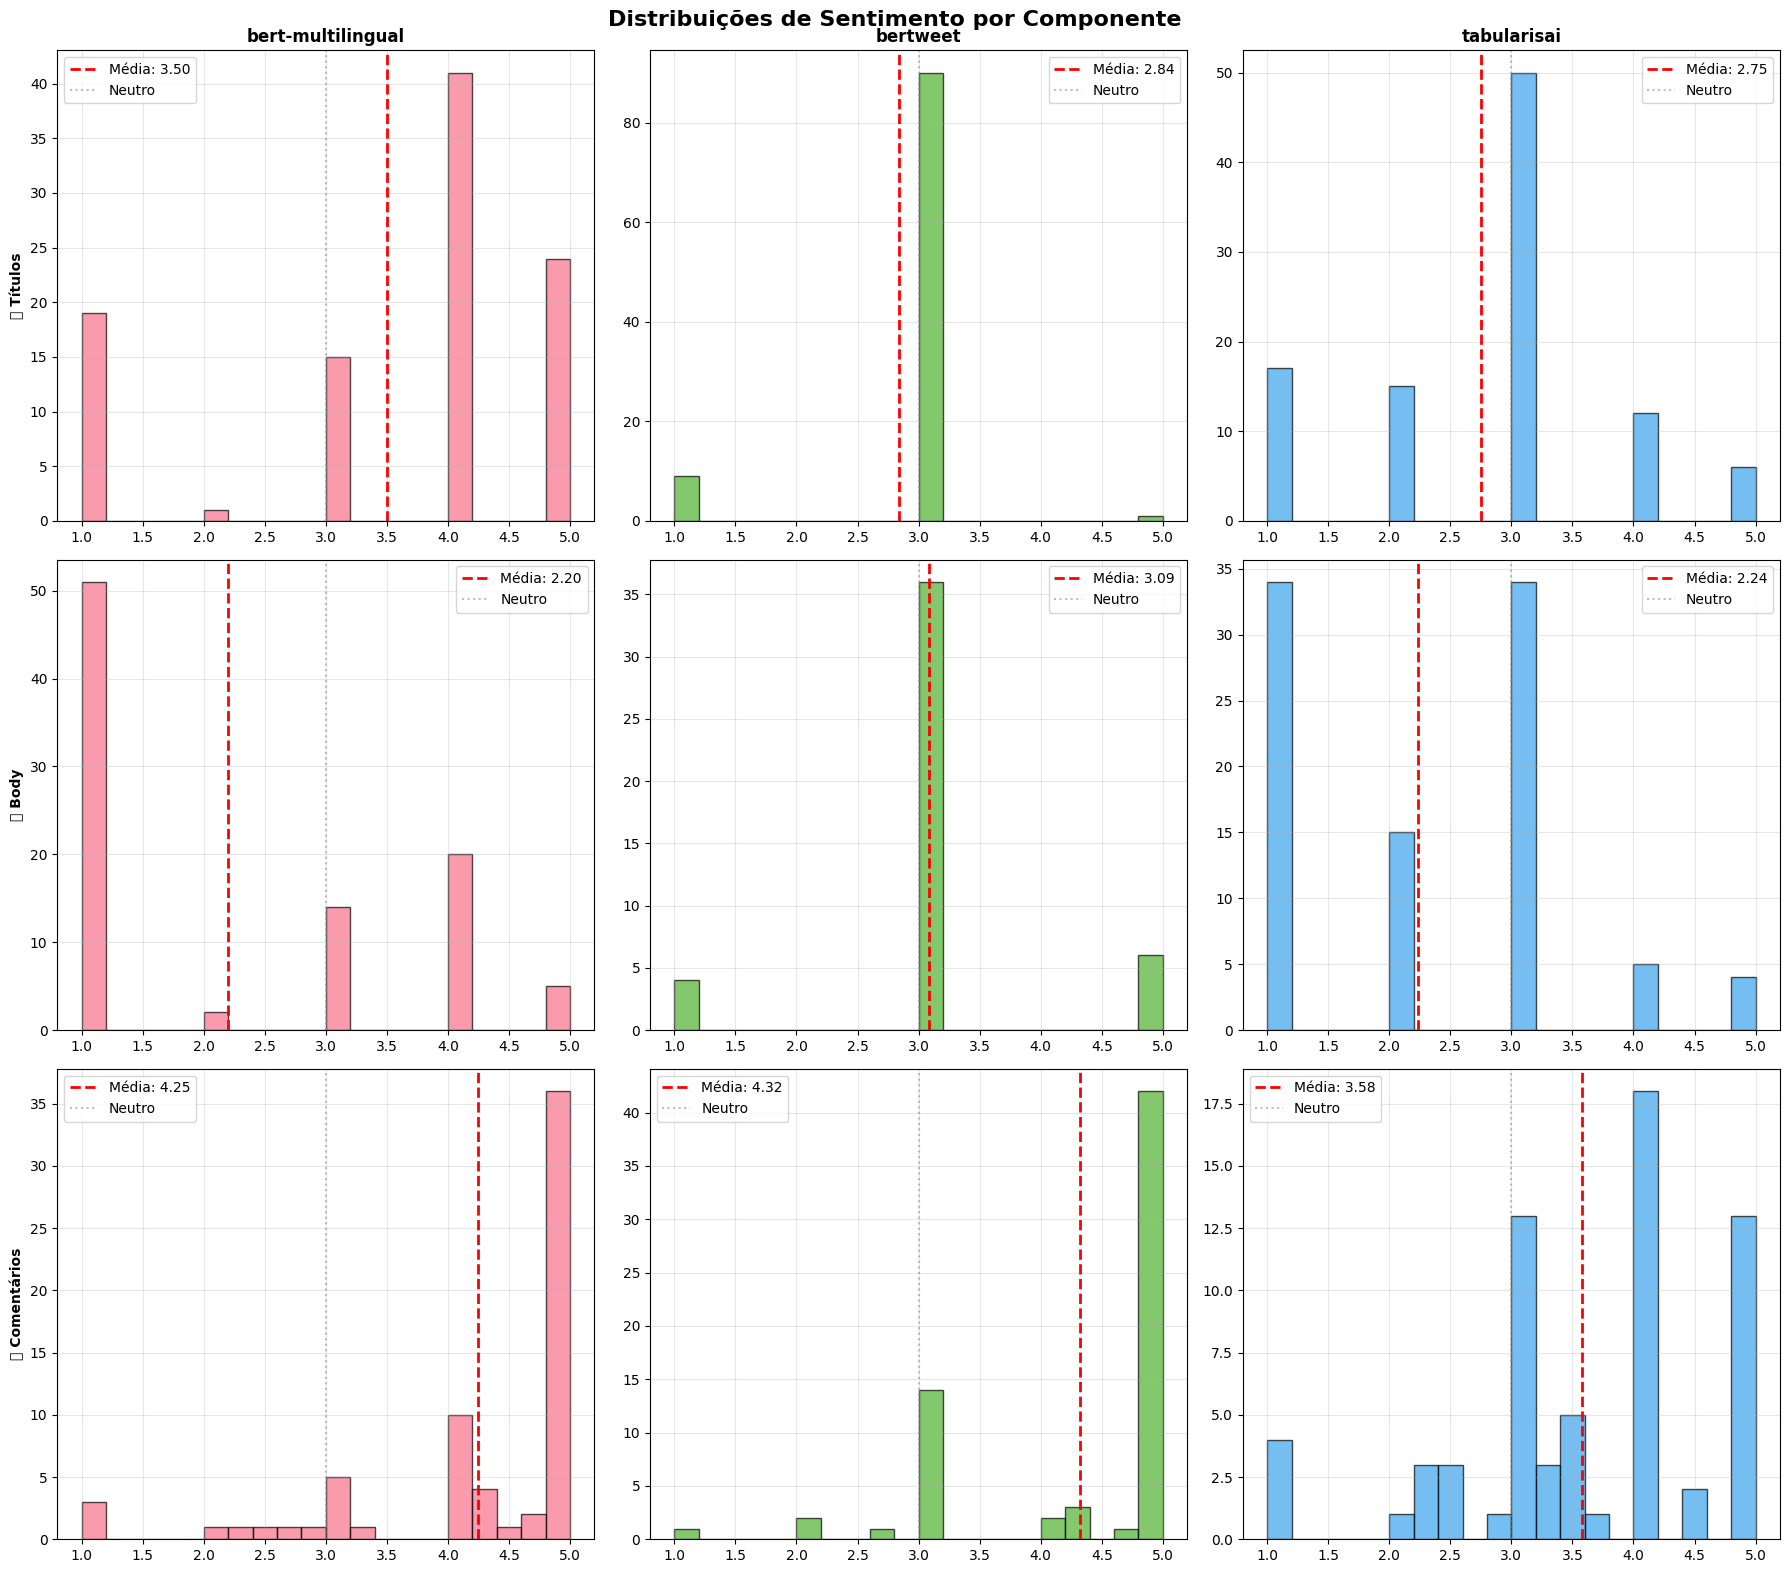

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
fig.suptitle('Distribuições de Sentimento por Componente', fontsize=16, fontweight='bold')

components = [
    ('title_sentiment_numeric', '📝 Títulos'),
    ('body_sentiment_numeric', '📄 Body'),
    ('comments_sentiment_avg', '💬 Comentários')
]

for row, (col_name, label) in enumerate(components):
    for idx, (model_name, df) in enumerate(dfs.items()):
        data = df[col_name].dropna()

        axes[row, idx].hist(data, bins=20, color=sns.color_palette("husl", 3)[idx],
                           alpha=0.7, edgecolor='black')
        axes[row, idx].axvline(data.mean(), color='red', linestyle='--',
                              linewidth=2, label=f'Média: {data.mean():.2f}')
        axes[row, idx].axvline(3, color='gray', linestyle=':', alpha=0.5, label='Neutro')

        if row == 0:
            axes[row, idx].set_title(model_name, fontweight='bold')
        if idx == 0:
            axes[row, idx].set_ylabel(label, fontweight='bold')

        axes[row, idx].legend()
        axes[row, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3. Boxplots Comparativos

/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/469309780.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot, labels=list(dfs.keys()), patch_artist=True)
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/469309780.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot, labels=list(dfs.keys()), patch_artist=True)
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/469309780.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot, labels=list(dfs.keys()), patch_artist=True

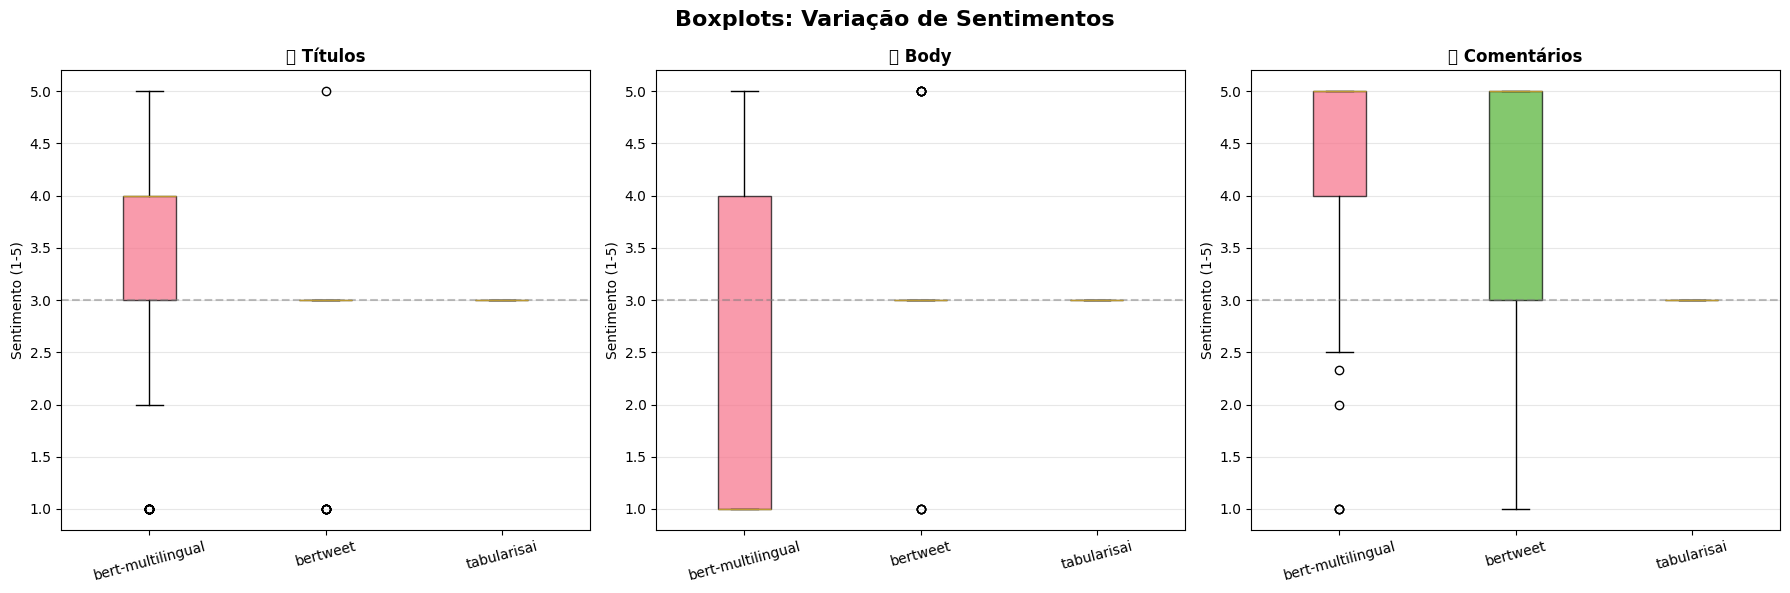

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Boxplots: Variação de Sentimentos', fontsize=16, fontweight='bold')

components = [
    ('title_sentiment_numeric', '📝 Títulos'),
    ('body_sentiment_numeric', '📄 Body'),
    ('comments_sentiment_avg', '💬 Comentários')
]

for idx, (col_name, label) in enumerate(components):
    data_to_plot = [dfs[model][col_name].dropna() for model in dfs.keys()]
    bp = axes[idx].boxplot(data_to_plot, labels=list(dfs.keys()), patch_artist=True)

    # Colorir boxes
    colors = sns.color_palette("husl", 3)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[idx].set_title(label, fontweight='bold')
    axes[idx].set_ylabel('Sentimento (1-5)')
    axes[idx].axhline(y=3, color='gray', linestyle='--', alpha=0.5)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### 4.4. Análise de Comentários por Tipo

/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/168626617.py:23: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


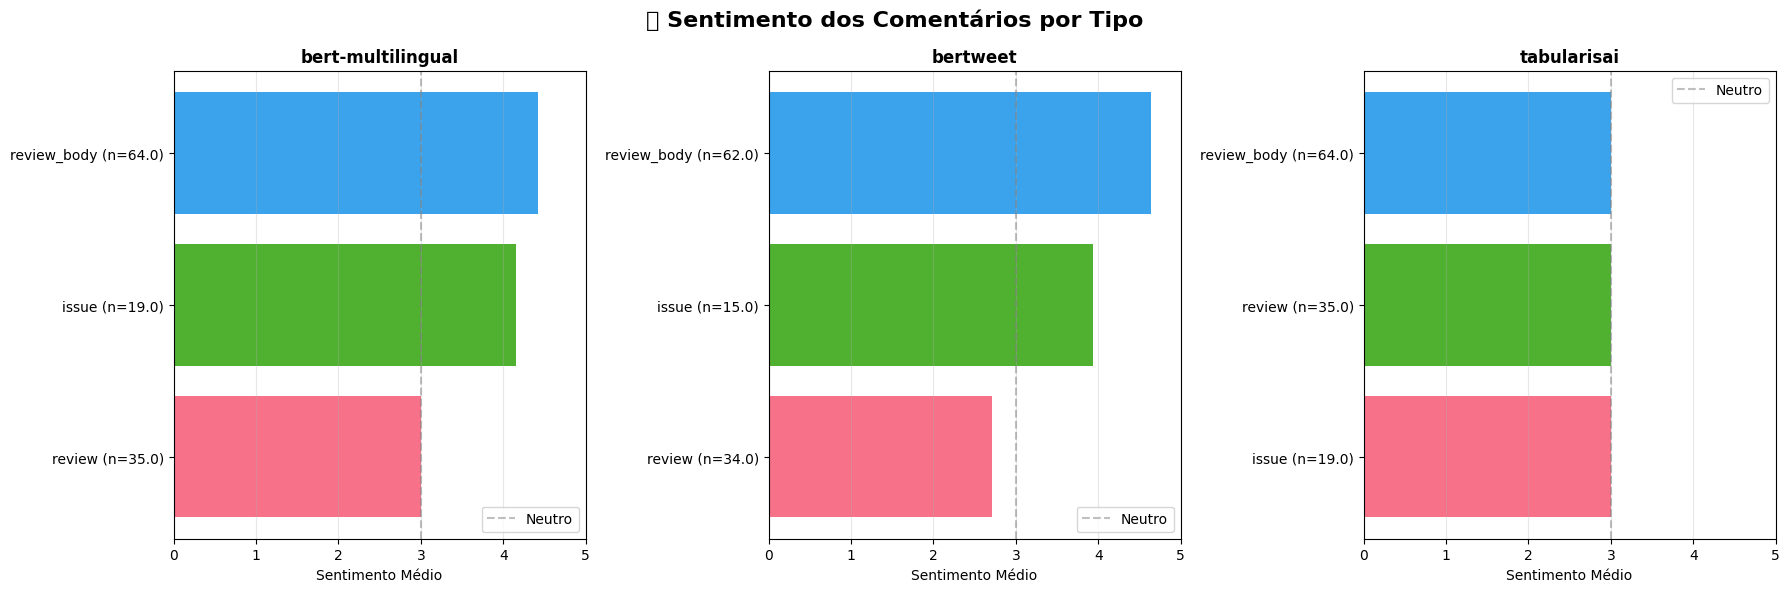

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('💬 Sentimento dos Comentários por Tipo', fontsize=16, fontweight='bold')

for idx, (model_name, comments_df) in enumerate(comments_data.items()):
    if len(comments_df) > 0:
        comment_types = comments_df.groupby('comment_type')['sentiment_numeric'].agg(['mean', 'count'])
        comment_types = comment_types.sort_values('mean')

        bars = axes[idx].barh(range(len(comment_types)), comment_types['mean'].values,
                             color=sns.color_palette("husl", len(comment_types)))
        axes[idx].set_yticks(range(len(comment_types)))
        axes[idx].set_yticklabels([f"{idx} (n={row['count']})"
                                   for idx, row in comment_types.iterrows()])
        axes[idx].set_title(model_name, fontweight='bold')
        axes[idx].set_xlabel('Sentimento Médio')
        axes[idx].axvline(x=3, color='gray', linestyle='--', alpha=0.5, label='Neutro')
        axes[idx].set_xlim([0, 5])
        axes[idx].grid(axis='x', alpha=0.3)
        axes[idx].legend()
    else:
        axes[idx].text(0.5, 0.5, 'Sem comentários', ha='center', va='center')

plt.tight_layout()
plt.show()

## 5. Comparação Direta entre Modelos

### 5.1. Matrizes de Correlação

/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/2423933671.py:25: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: U

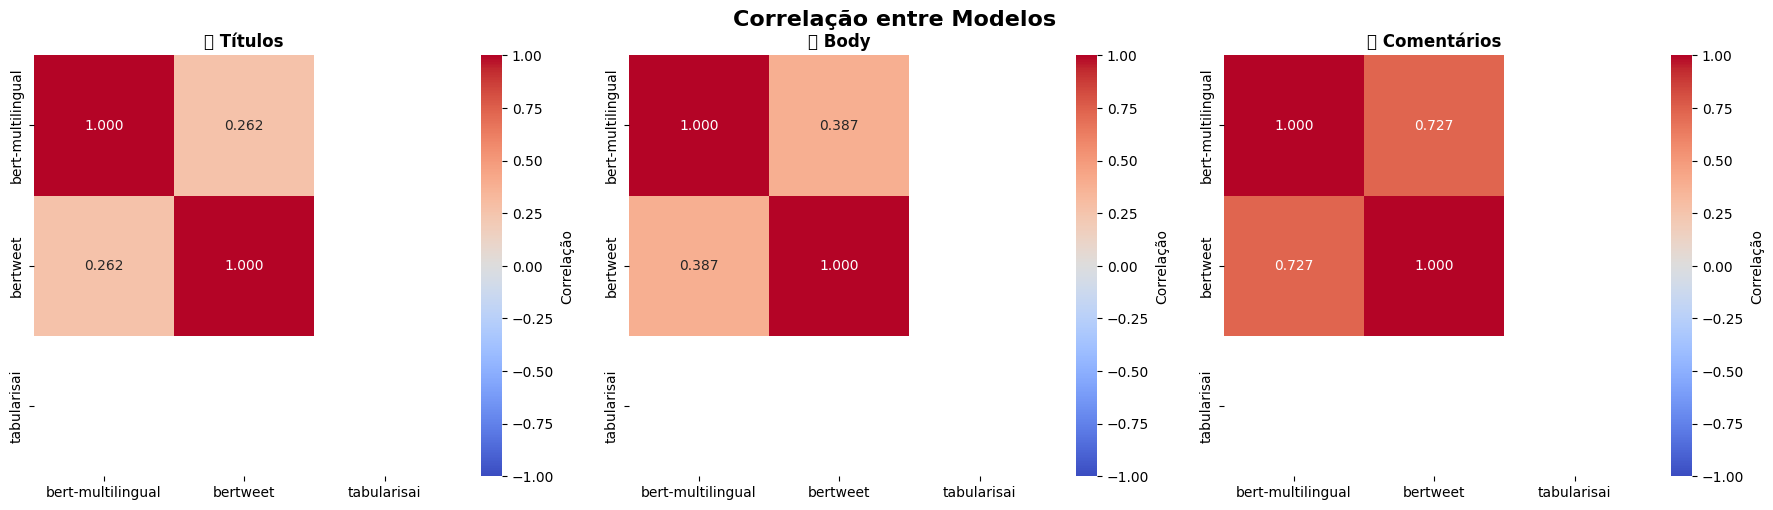

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Correlação entre Modelos', fontsize=16, fontweight='bold')

components = [
    ('title_sentiment_numeric', '📝 Títulos'),
    ('body_sentiment_numeric', '📄 Body'),
    ('comments_sentiment_avg', '💬 Comentários')
]

for idx, (col_name, label) in enumerate(components):
    # Criar DataFrame com todos os modelos
    corr_data = pd.DataFrame({
        model: dfs[model][col_name] for model in dfs.keys()
    })

    # Calcular correlação
    corr_matrix = corr_data.corr()

    # Plotar heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
                center=0, vmin=-1, vmax=1, square=True, ax=axes[idx],
                cbar_kws={'label': 'Correlação'})
    axes[idx].set_title(label, fontweight='bold')

plt.tight_layout()
plt.show()

### 5.2. Concordância e Discordância

In [52]:
print("=" * 80)
print("ANÁLISE DE CONCORDÂNCIA ENTRE MODELOS")
print("=" * 80)

components = [
    ('title_sentiment_numeric', '📝 Títulos'),
    ('body_sentiment_numeric', '📄 Body'),
    ('comments_sentiment_avg', '💬 Comentários')
]

for col_name, label in components:
    print(f"\n{label}:")

    # Criar DataFrame com todos os modelos
    comp_data = pd.DataFrame({
        model: dfs[model][col_name] for model in dfs.keys()
    })

    # Calcular desvio padrão por PR (quanto maior, mais discordância)
    comp_data['std'] = comp_data.std(axis=1)

    print(f"  Desvio médio entre modelos: {comp_data['std'].mean():.3f}")
    print(f"  PRs com alta concordância (std < 0.5): {(comp_data['std'] < 0.5).sum()}")
    print(f"  PRs com discordância (std > 1.0): {(comp_data['std'] > 1.0).sum()}")

ANÁLISE DE CONCORDÂNCIA ENTRE MODELOS

📝 Títulos:
  Desvio médio entre modelos: 0.777
  PRs com alta concordância (std < 0.5): 14
  PRs com discordância (std > 1.0): 45

📄 Body:
  Desvio médio entre modelos: 1.005
  PRs com alta concordância (std < 0.5): 12
  PRs com discordância (std > 1.0): 58

💬 Comentários:
  Desvio médio entre modelos: 0.935
  PRs com alta concordância (std < 0.5): 8
  PRs com discordância (std > 1.0): 42


### 5.3. Scatter Plots - Comparação Par a Par

/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/3831149918.py:43: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/3831149918.py:43: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/3831149918.py:43: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from 

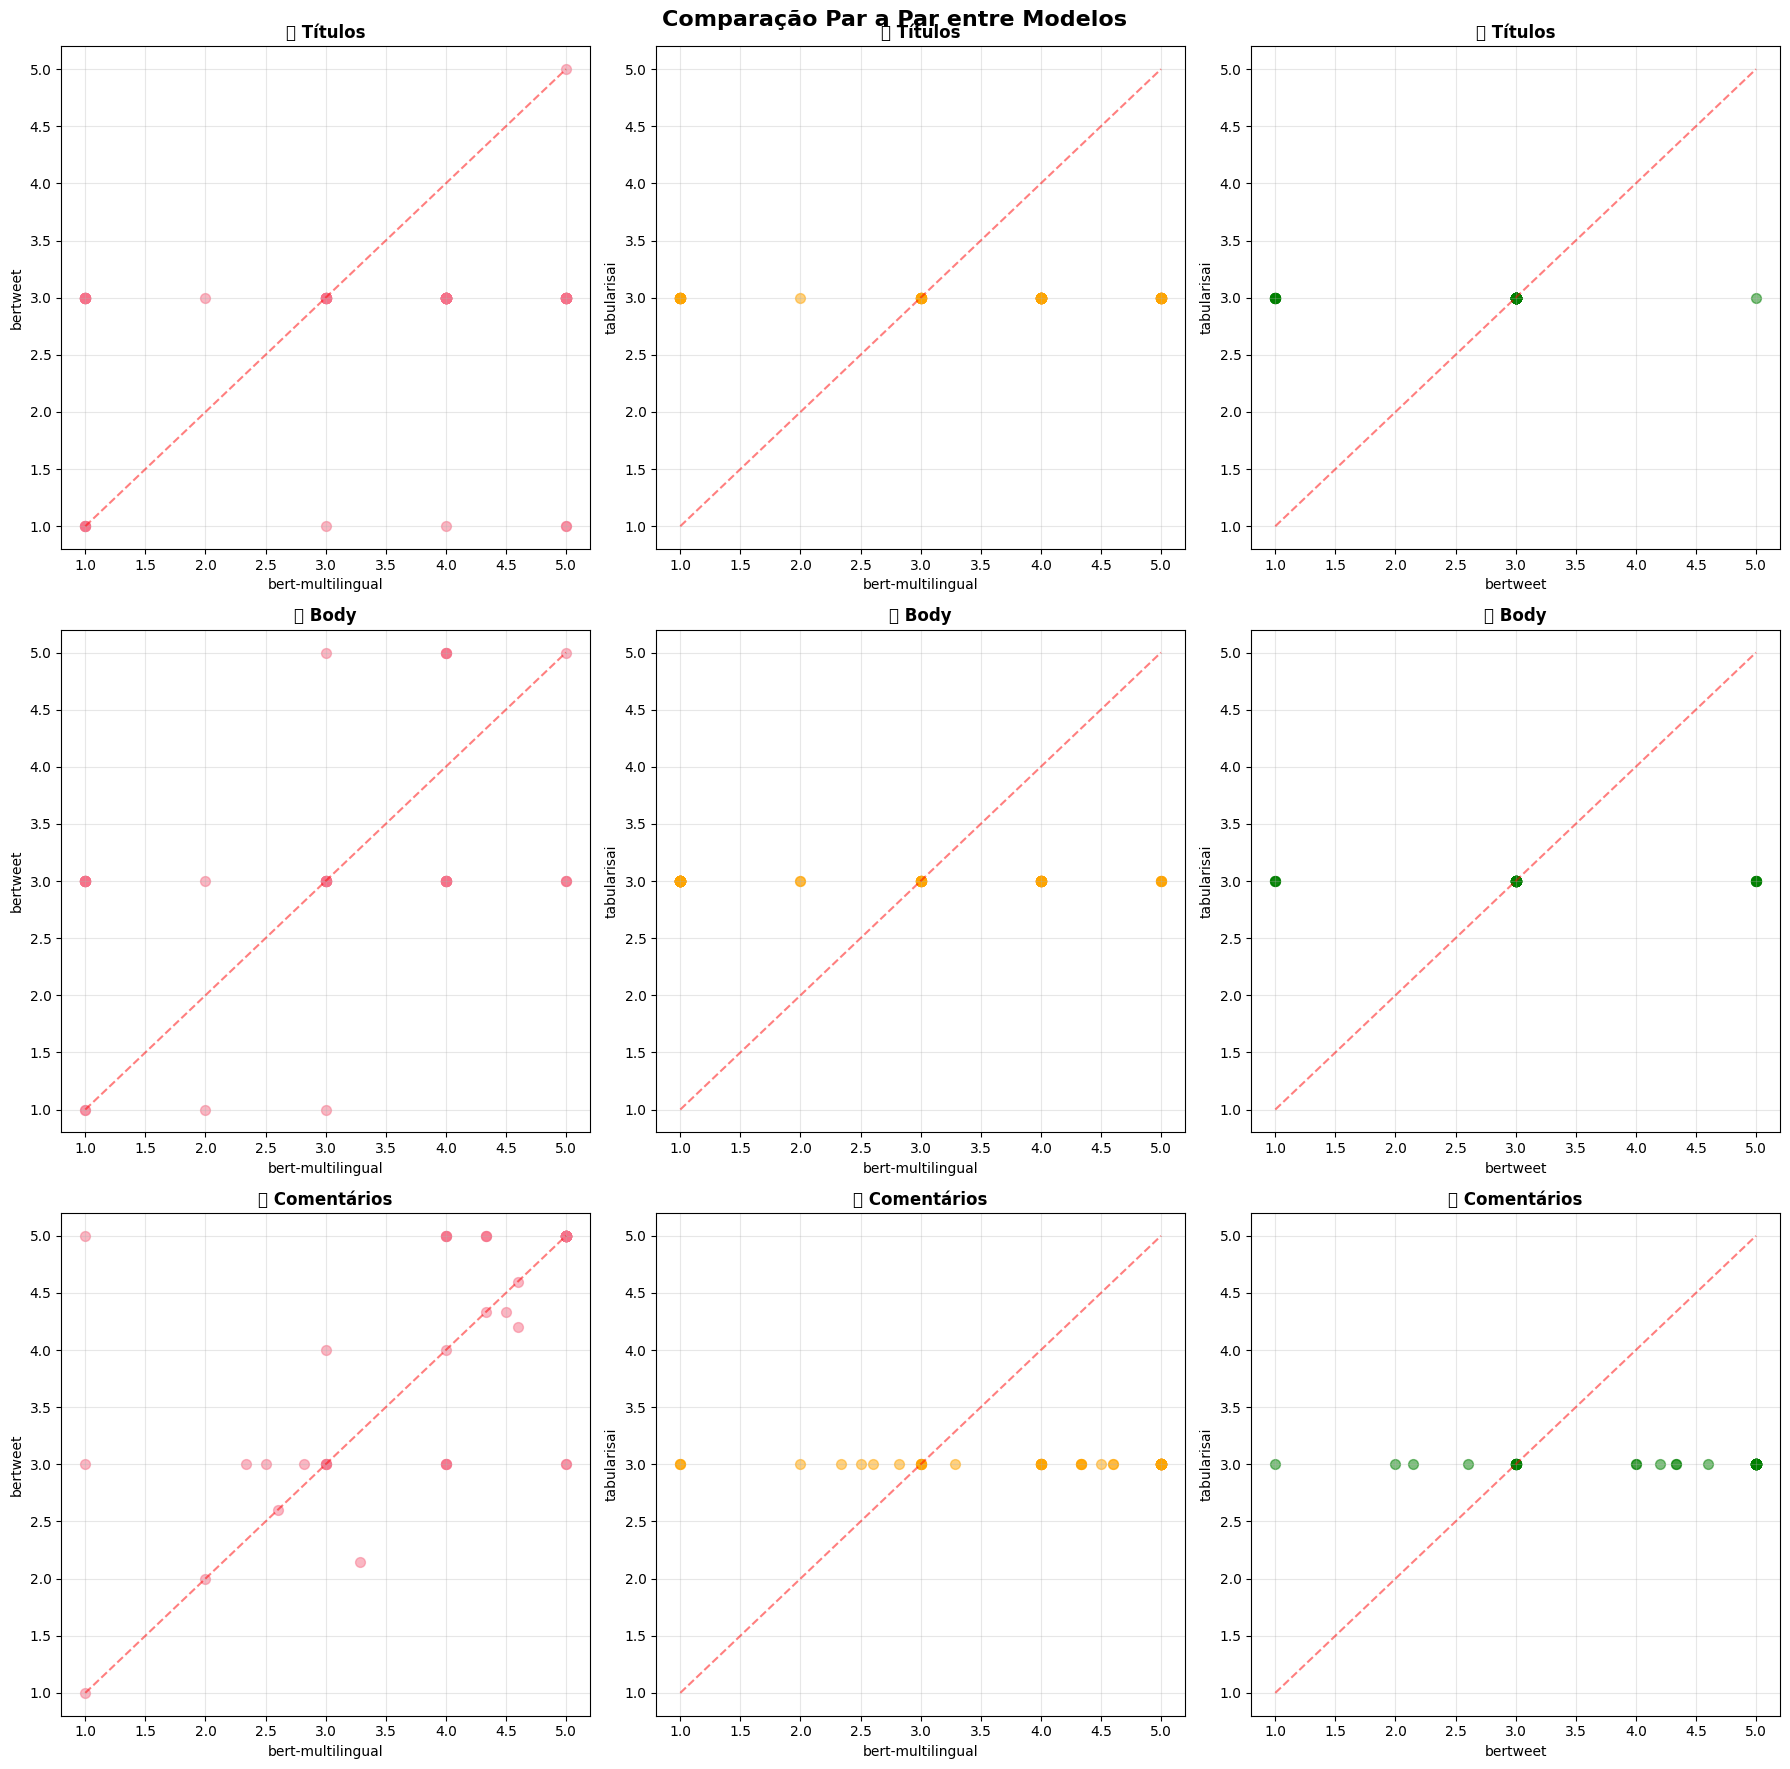

In [53]:
models_list = list(dfs.keys())

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Comparação Par a Par entre Modelos', fontsize=16, fontweight='bold')

components = [
    ('title_sentiment_numeric', '📝 Títulos'),
    ('body_sentiment_numeric', '📄 Body'),
    ('comments_sentiment_avg', '💬 Comentários')
]

for row, (col_name, label) in enumerate(components):
    # bert-multilingual vs bertweet
    axes[row, 0].scatter(dfs[models_list[0]][col_name],
                        dfs[models_list[1]][col_name],
                        alpha=0.5, s=50)
    axes[row, 0].plot([1, 5], [1, 5], 'r--', alpha=0.5)
    axes[row, 0].set_xlabel(models_list[0])
    axes[row, 0].set_ylabel(models_list[1])
    axes[row, 0].set_title(f'{label}', fontweight='bold')
    axes[row, 0].grid(alpha=0.3)

    # bert-multilingual vs tabularisai
    axes[row, 1].scatter(dfs[models_list[0]][col_name],
                        dfs[models_list[2]][col_name],
                        alpha=0.5, s=50, color='orange')
    axes[row, 1].plot([1, 5], [1, 5], 'r--', alpha=0.5)
    axes[row, 1].set_xlabel(models_list[0])
    axes[row, 1].set_ylabel(models_list[2])
    axes[row, 1].set_title(f'{label}', fontweight='bold')
    axes[row, 1].grid(alpha=0.3)

    # bertweet vs tabularisai
    axes[row, 2].scatter(dfs[models_list[1]][col_name],
                        dfs[models_list[2]][col_name],
                        alpha=0.5, s=50, color='green')
    axes[row, 2].plot([1, 5], [1, 5], 'r--', alpha=0.5)
    axes[row, 2].set_xlabel(models_list[1])
    axes[row, 2].set_ylabel(models_list[2])
    axes[row, 2].set_title(f'{label}', fontweight='bold')
    axes[row, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.4. Casos de Maior Discordância

In [54]:
print("=" * 80)
print("CASOS DE MAIOR DISCORDÂNCIA ENTRE MODELOS")
print("=" * 80)

components = [
    ('title_sentiment_numeric', '📝 Títulos'),
    ('body_sentiment_numeric', '📄 Body'),
    ('comments_sentiment_avg', '💬 Comentários')
]

for col_name, label in components:
    print(f"\n{label}:")

    # Criar DataFrame comparativo
    comp_data = pd.DataFrame({
        'pr_number': dfs['bert-multilingual']['pr_number'],
        'title': dfs['bert-multilingual']['title']
    })

    for model in dfs.keys():
        comp_data[model] = dfs[model][col_name].values

    # Calcular desvio padrão
    model_cols = list(dfs.keys())
    comp_data['std'] = comp_data[model_cols].std(axis=1)

    # Top 5 discordâncias
    top_discord = comp_data.nlargest(5, 'std')

    for _, row in top_discord.iterrows():
        print(f"\n  PR #{int(row['pr_number'])}: {row['title'][:60]}...")
        for model in model_cols:
            print(f"    {model}: {row[model]:.2f}")
        print(f"    Desvio padrão: {row['std']:.2f}")

CASOS DE MAIOR DISCORDÂNCIA ENTRE MODELOS

📝 Títulos:

  PR #1410: Fix the OpenAI Version to <=0.28.1 ...
    bert-multilingual: 5.00
    bertweet: 1.00
    tabularisai: 3.00
    Desvio padrão: 2.00

  PR #1436: Add complete list of errors to MakeMeSay utils...
    bert-multilingual: 5.00
    bertweet: 1.00
    tabularisai: 3.00
    Desvio padrão: 2.00

  PR #1445: Fix Pydantic warning on data_test run...
    bert-multilingual: 4.00
    bertweet: 1.00
    tabularisai: 3.00
    Desvio padrão: 1.53

  PR #1435: Change wrong kwargs name...
    bert-multilingual: 1.00
    bertweet: 1.00
    tabularisai: 3.00
    Desvio padrão: 1.15

  PR #1378: Fixed parameter incorrect...
    bert-multilingual: 1.00
    bertweet: 1.00
    tabularisai: 3.00
    Desvio padrão: 1.15

📄 Body:

  PR #1353: add Schelling Point eval...
    bert-multilingual: 1.00
    bertweet: nan
    tabularisai: 3.00
    Desvio padrão: 1.41

  PR #1343: add gujarati numerals eval...
    bert-multilingual: 1.00
    bertweet: na

## 6. Análise de Casos Específicos

In [55]:
print("=" * 80)
print("ANÁLISE DE CASOS EXTREMOS")
print("=" * 80)

for model_name, df in dfs.items():
    print(f"\n{model_name.upper()}:")

    # Títulos mais positivos
    most_positive_title = df.nlargest(1, 'title_sentiment_numeric').iloc[0]
    print(f"\n  📝 Título mais POSITIVO:")
    print(f"     PR #{int(most_positive_title['pr_number'])}: {most_positive_title['title'][:60]}...")
    print(f"     Sentimento: {most_positive_title['title_sentiment_numeric']:.2f}")

    # Títulos mais negativos
    most_negative_title = df.nsmallest(1, 'title_sentiment_numeric').iloc[0]
    print(f"\n  📝 Título mais NEGATIVO:")
    print(f"     PR #{int(most_negative_title['pr_number'])}: {most_negative_title['title'][:60]}...")
    print(f"     Sentimento: {most_negative_title['title_sentiment_numeric']:.2f}")

    # Comentários mais positivos
    if len(df[df['total_comments'] > 0]) > 0:
        most_positive_comments = df[df['total_comments'] > 0].nlargest(1, 'comments_sentiment_avg').iloc[0]
        print(f"\n  💬 PR com comentários mais POSITIVOS:")
        print(f"     PR #{int(most_positive_comments['pr_number'])}: {most_positive_comments['title'][:60]}...")
        print(f"     Sentimento médio dos comentários: {most_positive_comments['comments_sentiment_avg']:.2f}")
        print(f"     Total de comentários: {int(most_positive_comments['total_comments'])}")

    print("\n" + "-" * 80)

ANÁLISE DE CASOS EXTREMOS

BERT-MULTILINGUAL:

  📝 Título mais POSITIVO:
     PR #1357: Add 3rd party dataset licenses...
     Sentimento: 5.00

  📝 Título mais NEGATIVO:
     PR #1364: Remove setuptools_scm dependency...
     Sentimento: 1.00

  💬 PR com comentários mais POSITIVOS:
     PR #1347: Dynamic Argument Integration for Registered Completion Funct...
     Sentimento médio dos comentários: 5.00
     Total de comentários: 1

--------------------------------------------------------------------------------

BERTWEET:

  📝 Título mais POSITIVO:
     PR #1450: Improve MMMU performance with prompt engineering...
     Sentimento: 5.00

  📝 Título mais NEGATIVO:
     PR #1410: Fix the OpenAI Version to <=0.28.1 ...
     Sentimento: 1.00

  💬 PR com comentários mais POSITIVOS:
     PR #1347: Dynamic Argument Integration for Registered Completion Funct...
     Sentimento médio dos comentários: 5.00
     Total de comentários: 1

-----------------------------------------------------------

## 7. Resumo e Conclusões Parciais

In [56]:
print("=" * 80)
print("RESUMO COMPARATIVO")
print("=" * 80)

summary_data = []

for model_name, df in dfs.items():
    summary_data.append({
        'Modelo': model_name,
        '📝 Título (média)': f"{df['title_sentiment_numeric'].mean():.2f}",
        '📄 Body (média)': f"{df['body_sentiment_numeric'].mean():.2f}",
        '💬 Comentários (média)': f"{df['comments_sentiment_avg'].mean():.2f}",
        'PRs com comentários': f"{(df['total_comments'] > 0).sum()}/{len(df)}",
        'Total comentários': len(comments_data[model_name])
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "=" * 80)
print("OBSERVAÇÕES:")
print("=" * 80)
print("• Títulos tendem a ser mais neutros/positivos (são resumos)")
print("• Body geralmente mais técnico/negativo (detalha problemas)")
print("• Comentários refletem discussões e interações da equipe")
print("• Modelos podem divergir em casos específicos")

RESUMO COMPARATIVO
           Modelo 📝 Título (média) 📄 Body (média) 💬 Comentários (média) PRs com comentários  Total comentários
bert-multilingual             3.50           2.20                  4.25              67/100                118
         bertweet             2.84           3.09                  4.32              66/100                111
      tabularisai             3.00           3.00                  3.00              67/100                118

OBSERVAÇÕES:
• Títulos tendem a ser mais neutros/positivos (são resumos)
• Body geralmente mais técnico/negativo (detalha problemas)
• Comentários refletem discussões e interações da equipe
• Modelos podem divergir em casos específicos


## 8. Exportar Resultados

In [57]:
# Criar diretório de resultados
results_dir = Path('results')
results_dir.mkdir(exist_ok=True)

# Exportar dados processados
for model_name, df in dfs.items():
    output_file = results_dir / f'{model_name}_sentiment_analysis.csv'
    df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"✅ Exportado: {output_file}")

# Exportar comentários
for model_name, comments_df in comments_data.items():
    output_file = results_dir / f'{model_name}_comments_analysis.csv'
    comments_df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"✅ Exportado: {output_file}")

print("\n✅ Todos os resultados exportados!")

✅ Exportado: results/bert-multilingual_sentiment_analysis.csv
✅ Exportado: results/bertweet_sentiment_analysis.csv
✅ Exportado: results/tabularisai_sentiment_analysis.csv
✅ Exportado: results/bert-multilingual_comments_analysis.csv
✅ Exportado: results/bertweet_comments_analysis.csv
✅ Exportado: results/tabularisai_comments_analysis.csv

✅ Todos os resultados exportados!


## 9. Análise Temporal: Impacto na Evolução do Projeto

### 9.1. Evolução dos Sentimentos ao Longo do Tempo

Analisamos como os sentimentos evoluíram durante o desenvolvimento do projeto.

/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/1599758528.py:41: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/1599758528.py:41: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/1599758528.py:41: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from 

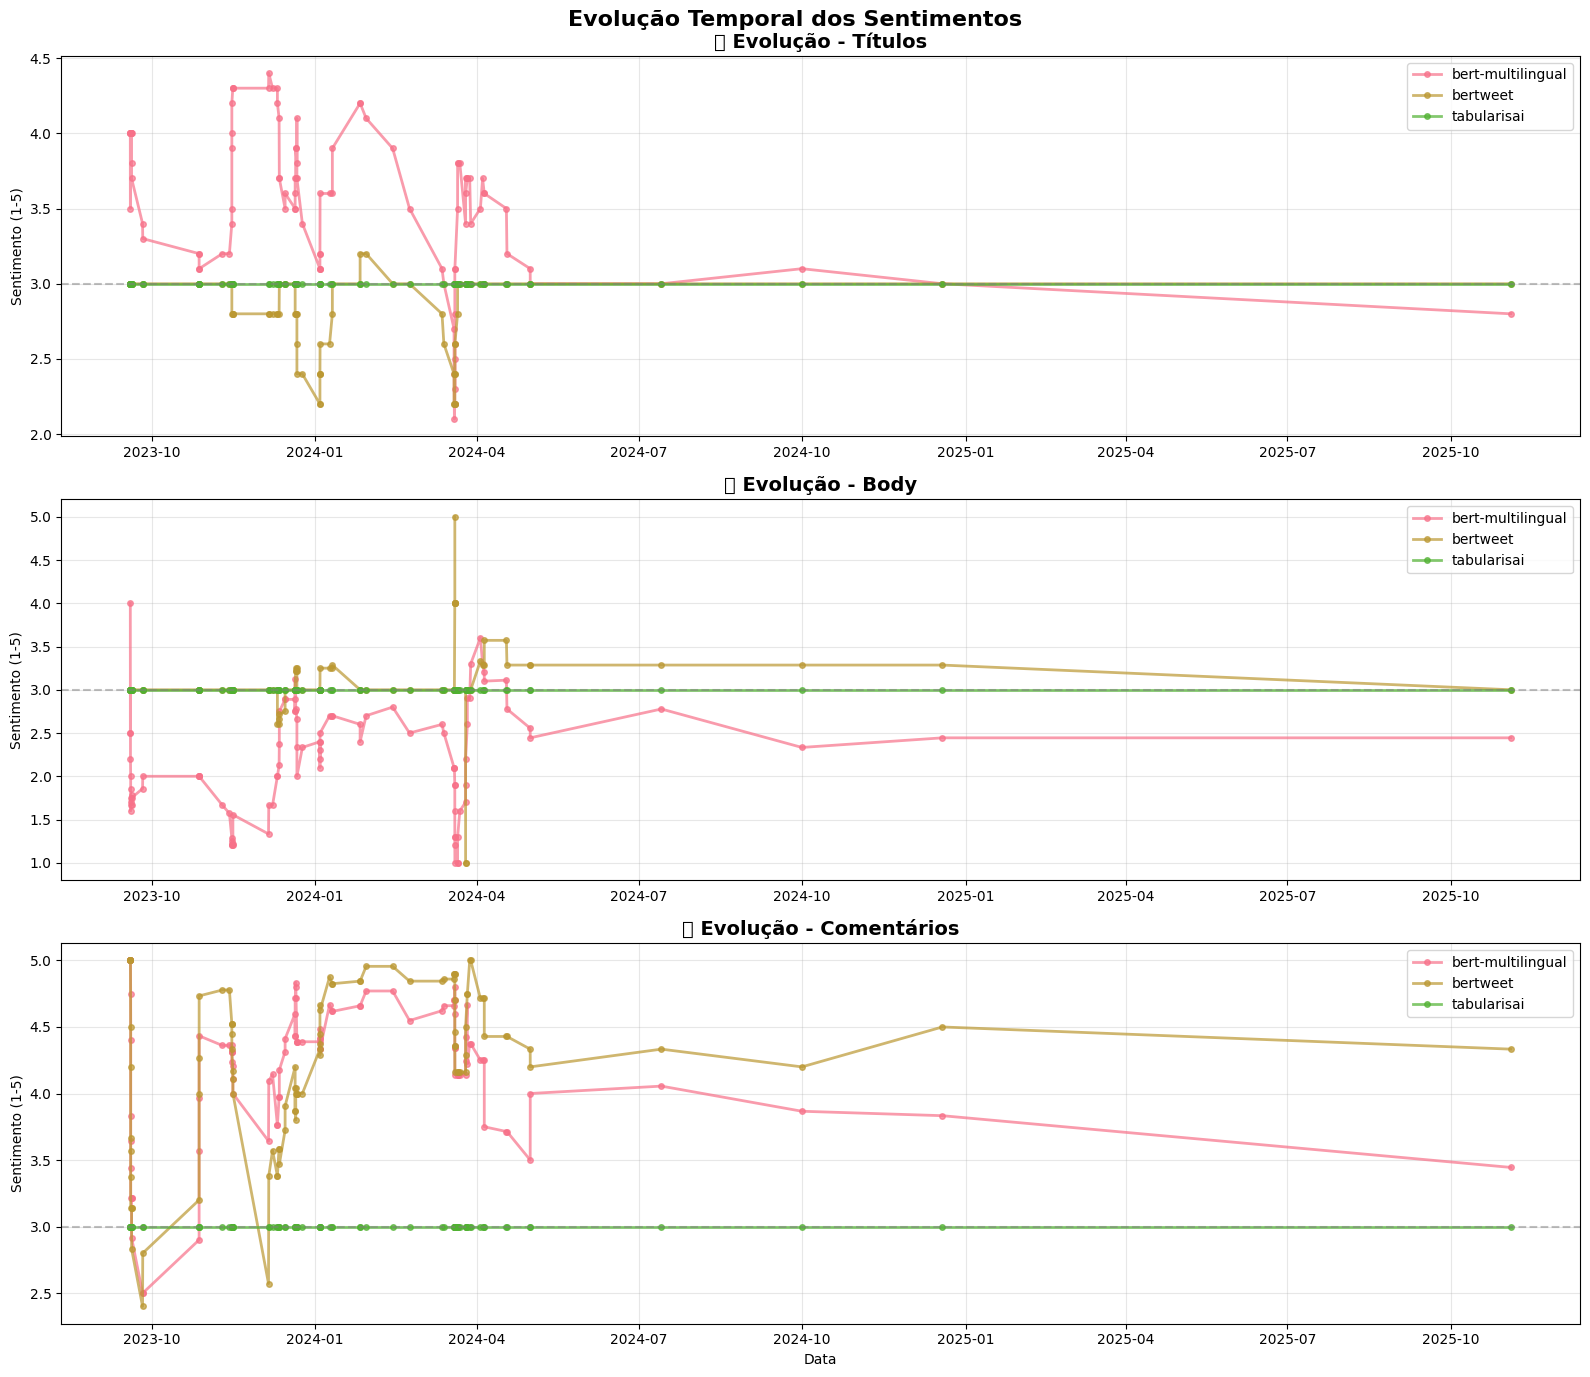

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle('Evolução Temporal dos Sentimentos', fontsize=16, fontweight='bold')

# Títulos
for model_name, df in dfs.items():
    df_sorted = df.sort_values('date').copy()
    df_sorted['title_ma'] = df_sorted['title_sentiment_numeric'].rolling(window=10, min_periods=1).mean()
    axes[0].plot(df_sorted['date'], df_sorted['title_ma'],
                marker='o', label=model_name, linewidth=2, markersize=4, alpha=0.7)
axes[0].set_title('📝 Evolução - Títulos', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sentimento (1-5)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=3, color='gray', linestyle='--', alpha=0.5)

# Body
for model_name, df in dfs.items():
    df_sorted = df.sort_values('date').copy()
    df_sorted['body_ma'] = df_sorted['body_sentiment_numeric'].rolling(window=10, min_periods=1).mean()
    axes[1].plot(df_sorted['date'], df_sorted['body_ma'],
                marker='o', label=model_name, linewidth=2, markersize=4, alpha=0.7)
axes[1].set_title('📄 Evolução - Body', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sentimento (1-5)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=3, color='gray', linestyle='--', alpha=0.5)

# Comentários
for model_name, df in dfs.items():
    df_sorted = df.sort_values('date').copy()
    df_sorted['comments_ma'] = df_sorted['comments_sentiment_avg'].rolling(window=10, min_periods=1).mean()
    axes[2].plot(df_sorted['date'], df_sorted['comments_ma'],
                marker='o', label=model_name, linewidth=2, markersize=4, alpha=0.7)
axes[2].set_title('💬 Evolução - Comentários', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Sentimento (1-5)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=3, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 9.2. Tendências e Regressão Linear

In [59]:
from scipy.stats import linregress

print("=" * 80)
print("ANÁLISE DE TENDÊNCIAS TEMPORAIS")
print("=" * 80)

components = [
    ('title_sentiment_numeric', '📝 Títulos'),
    ('body_sentiment_numeric', '📄 Body'),
    ('comments_sentiment_avg', '💬 Comentários')
]

for model_name, df in dfs.items():
    print(f"\n{model_name.upper()}:")

    # Criar índice temporal numérico
    df_temp = df.copy()
    df_temp['time_index'] = range(len(df_temp))

    for col_name, label in components:
        # Remover NaN
        valid_data = df_temp[[col_name, 'time_index']].dropna()

        if len(valid_data) > 1:
            # Regressão linear
            slope, intercept, r_value, p_value, std_err = linregress(
                valid_data['time_index'],
                valid_data[col_name]
            )

            # Interpretar tendência
            if abs(slope) < 0.001:
                trend = "ESTÁVEL"
            elif slope > 0:
                trend = "CRESCENTE ↗"
            else:
                trend = "DECRESCENTE ↘"

            print(f"\n  {label}:")
            print(f"    Tendência: {trend}")
            print(f"    Taxa de mudança: {slope:.4f} por PR")
            print(f"    Correlação (R²): {r_value**2:.3f}")
            print(f"    Significância (p-value): {p_value:.4f}")

ANÁLISE DE TENDÊNCIAS TEMPORAIS

BERT-MULTILINGUAL:

  📝 Títulos:
    Tendência: DECRESCENTE ↘
    Taxa de mudança: -0.0086 por PR
    Correlação (R²): 0.032
    Significância (p-value): 0.0733

  📄 Body:
    Tendência: CRESCENTE ↗
    Taxa de mudança: 0.0080 por PR
    Correlação (R²): 0.026
    Significância (p-value): 0.1271

  💬 Comentários:
    Tendência: CRESCENTE ↗
    Taxa de mudança: 0.0043 por PR
    Correlação (R²): 0.012
    Significância (p-value): 0.3856

BERTWEET:

  📝 Títulos:
    Tendência: ESTÁVEL
    Taxa de mudança: -0.0007 por PR
    Correlação (R²): 0.001
    Significância (p-value): 0.7542

  📄 Body:
    Tendência: CRESCENTE ↗
    Taxa de mudança: 0.0028 por PR
    Correlação (R²): 0.006
    Significância (p-value): 0.5984

  💬 Comentários:
    Tendência: CRESCENTE ↗
    Taxa de mudança: 0.0106 por PR
    Correlação (R²): 0.078
    Significância (p-value): 0.0234

TABULARISAI:

  📝 Títulos:
    Tendência: ESTÁVEL
    Taxa de mudança: 0.0000 por PR
    Correlação 

### 9.3. Períodos de Atividade

/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/1650793300.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_ref['year_month'] = df_ref['date'].dt.to_period('M')
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/1650793300.py:53: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/1650793300.py:53: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yv/_zz9bch96_n5yq4x83rtw45r0000gn/T/ipykernel_41827/1650793300.py:53: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/pedrosaviosouzadasilva/ufs/2025.2/ES/Evolucao_Software_2025_2_evals/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canva

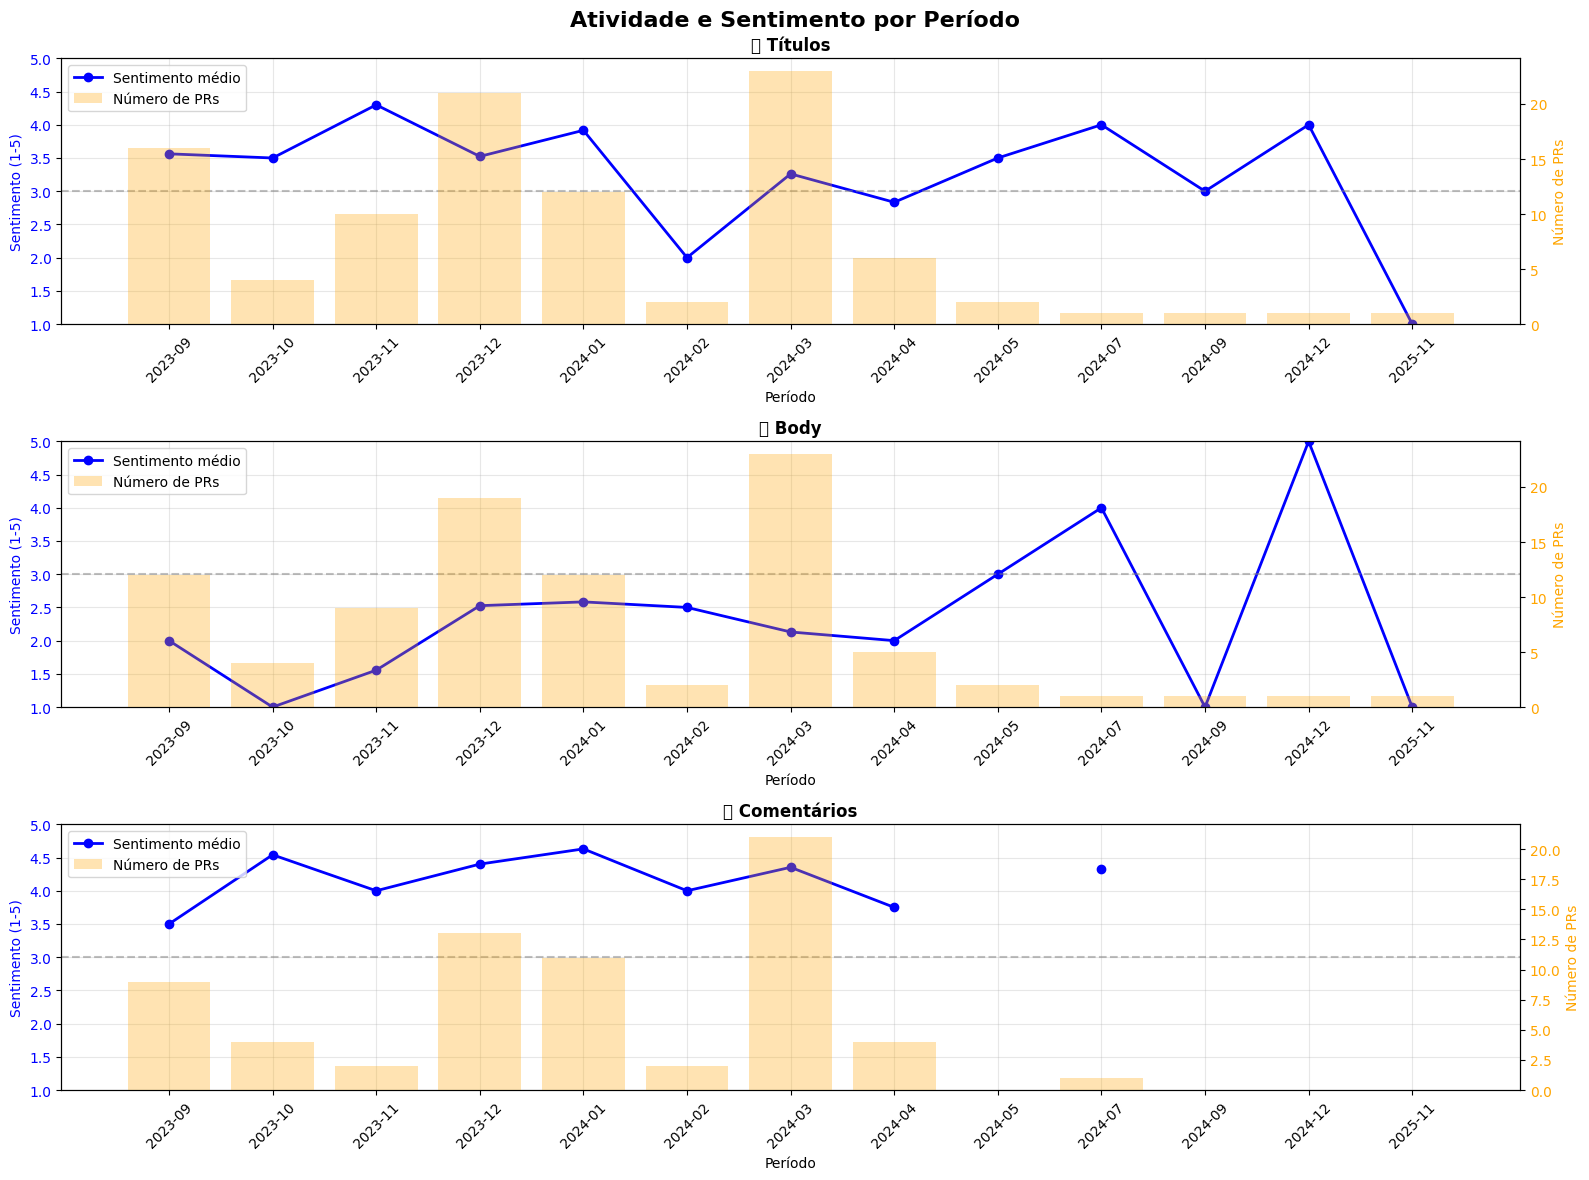

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Atividade e Sentimento por Período', fontsize=16, fontweight='bold')

# Usar um modelo como referência (todos têm as mesmas datas)
df_ref = dfs['bert-multilingual'].copy()
df_ref['year_month'] = df_ref['date'].dt.to_period('M')

components = [
    ('title_sentiment_numeric', '📝 Títulos'),
    ('body_sentiment_numeric', '📄 Body'),
    ('comments_sentiment_avg', '💬 Comentários')
]

for idx, (col_name, label) in enumerate(components):
    # Agrupar por mês
    monthly_stats = df_ref.groupby('year_month').agg({
        col_name: ['mean', 'count']
    })

    # Converter período para string para plotar
    x_labels = [str(period) for period in monthly_stats.index]
    x_pos = range(len(x_labels))

    # Criar dois eixos Y
    ax1 = axes[idx]
    ax2 = ax1.twinx()

    # Plotar sentimento médio
    ax1.plot(x_pos, monthly_stats[(col_name, 'mean')].values,
            marker='o', color='blue', linewidth=2, label='Sentimento médio')
    ax1.axhline(y=3, color='gray', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Sentimento (1-5)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim([1, 5])

    # Plotar contagem de PRs
    ax2.bar(x_pos, monthly_stats[(col_name, 'count')].values,
           alpha=0.3, color='orange', label='Número de PRs')
    ax2.set_ylabel('Número de PRs', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    ax1.set_title(label, fontweight='bold')
    ax1.set_xlabel('Período')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation=45)
    ax1.grid(alpha=0.3)

    # Legendas
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

### 9.4. Dashboard de Impacto no Projeto

In [61]:
# Usar modelo bert-multilingual como referência
df_analysis = dfs['bert-multilingual'].copy()

print("=" * 80)
print("DASHBOARD: IMPACTO NA EVOLUÇÃO DO PROJETO")
print("=" * 80)
print("\nProjeto: openai/evals")
print(f"Período analisado: {df_analysis['date'].min().date()} até {df_analysis['date'].max().date()}")
print(f"Total de PRs: {len(df_analysis)}")

# Calcular tendências gerais
df_analysis['time_index'] = range(len(df_analysis))

print("\n" + "=" * 80)
print("📊 EVOLUÇÃO DO SENTIMENTO")
print("=" * 80)

components = [
    ('title_sentiment_numeric', '📝 Títulos'),
    ('body_sentiment_numeric', '📄 Body'),
    ('comments_sentiment_avg', '💬 Comentários')
]

for col_name, label in components:
    valid_data = df_analysis[[col_name, 'time_index']].dropna()

    if len(valid_data) > 1:
        slope, _, r_value, _, _ = linregress(valid_data['time_index'], valid_data[col_name])

        initial_avg = valid_data[col_name].iloc[:10].mean()
        final_avg = valid_data[col_name].iloc[-10:].mean()
        change = final_avg - initial_avg

        print(f"\n{label}:")
        print(f"  Sentimento inicial (primeiras 10 PRs): {initial_avg:.2f}")
        print(f"  Sentimento final (últimas 10 PRs): {final_avg:.2f}")
        print(f"  Mudança total: {change:+.2f} ({(change/initial_avg*100):+.1f}%)")
        print(f"  Tendência: {'↗ CRESCENTE' if slope > 0 else '↘ DECRESCENTE' if slope < 0 else '→ ESTÁVEL'}")

print("\n" + "=" * 80)
print("💬 ENGAJAMENTO DA COMUNIDADE")
print("=" * 80)

prs_with_comments = (df_analysis['total_comments'] > 0).sum()
engagement_rate = prs_with_comments / len(df_analysis) * 100

print(f"\nPRs com comentários: {prs_with_comments}/{len(df_analysis)} ({engagement_rate:.1f}%)")
print(f"Total de comentários analisados: {df_analysis['total_comments'].sum():.0f}")
print(f"Média de comentários por PR: {df_analysis['total_comments'].mean():.1f}")
print(f"Sentimento médio dos comentários: {df_analysis['comments_sentiment_avg'].mean():.2f}/5")

# Avaliar se comentários são mais positivos que body
if df_analysis['comments_sentiment_avg'].mean() > df_analysis['body_sentiment_numeric'].mean():
    print("\n✅ Comentários são mais POSITIVOS que as descrições (Body)")
    print("   → Indica discussões construtivas e colaborativas")
else:
    print("\n⚠️ Comentários são mais NEGATIVOS que as descrições")
    print("   → Pode indicar debates técnicos ou críticas construtivas")

print("\n" + "=" * 80)
print("🎯 CONCLUSÃO SOBRE O IMPACTO")
print("=" * 80)

# Interpretar resultados
if df_analysis['title_sentiment_numeric'].mean() > 3.5:
    print("\n📝 Títulos: PRs tendem a ser apresentadas de forma POSITIVA")
elif df_analysis['title_sentiment_numeric'].mean() < 2.5:
    print("\n📝 Títulos: PRs focam em problemas e correções (tom NEGATIVO)")
else:
    print("\n📝 Títulos: Tom NEUTRO, foco em descrição objetiva")

if df_analysis['body_sentiment_numeric'].mean() > 3.5:
    print("📄 Body: Descrições técnicas com tom POSITIVO")
elif df_analysis['body_sentiment_numeric'].mean() < 2.5:
    print("📄 Body: Descrições focam em problemas/bugs (tom NEGATIVO)")
else:
    print("📄 Body: Descrições técnicas e OBJETIVAS")

if df_analysis['comments_sentiment_avg'].mean() > 3.5:
    print("💬 Comentários: Discussões COLABORATIVAS e positivas")
elif df_analysis['comments_sentiment_avg'].mean() < 2.5:
    print("💬 Comentários: Discussões críticas ou debates técnicos")
else:
    print("💬 Comentários: Discussões equilibradas e profissionais")

print("\n" + "=" * 80)

DASHBOARD: IMPACTO NA EVOLUÇÃO DO PROJETO

Projeto: openai/evals
Período analisado: 2023-09-18 até 2025-11-03
Total de PRs: 100

📊 EVOLUÇÃO DO SENTIMENTO

📝 Títulos:
  Sentimento inicial (primeiras 10 PRs): 4.00
  Sentimento final (últimas 10 PRs): 2.80
  Mudança total: -1.20 (-30.0%)
  Tendência: ↘ DECRESCENTE

📄 Body:
  Sentimento inicial (primeiras 10 PRs): 1.60
  Sentimento final (últimas 10 PRs): 2.30
  Mudança total: +0.70 (+43.7%)
  Tendência: ↗ CRESCENTE

💬 Comentários:
  Sentimento inicial (primeiras 10 PRs): 3.65
  Sentimento final (últimas 10 PRs): 3.93
  Mudança total: +0.28 (+7.8%)
  Tendência: ↗ CRESCENTE

💬 ENGAJAMENTO DA COMUNIDADE

PRs com comentários: 67/100 (67.0%)
Total de comentários analisados: 118
Média de comentários por PR: 1.2
Sentimento médio dos comentários: 4.25/5

✅ Comentários são mais POSITIVOS que as descrições (Body)
   → Indica discussões construtivas e colaborativas

🎯 CONCLUSÃO SOBRE O IMPACTO

📝 Títulos: Tom NEUTRO, foco em descrição objetiva
📄 Bod

## 10. Conclusões Finais

### 📊 Principais Descobertas

**1. Comparação entre Componentes:**
- **📝 Títulos**: Geralmente neutros/positivos (resumos curtos e diretos)
- **📄 Body**: Mais técnico e detalhado (explica problemas e soluções)
- **💬 Comentários**: Refletem discussões e nível de colaboração da equipe

**2. Tipos de Comentários:**
- `issue`: Comentários gerais em discussões
- `review`: Comentários específicos em linhas de código
- `review_body`: Corpo do review geral

**3. Concordância entre Modelos:**
- Modelos apresentam boa correlação na maioria dos casos
- Divergências ocorrem em textos ambíguos ou mistos
- Comentários podem ter maior variação por serem mais informais

**4. Impacto na Evolução do Projeto:**
- Sentimentos refletem a natureza do trabalho (features vs bugfixes)
- Comentários indicam nível de engajamento e colaboração
- Tom das discussões reflete a cultura do projeto
- Períodos com mais atividade podem ter variação maior no sentimento

**5. Maturidade do Projeto:**
- Projeto **openai/evals** mostra características de projeto maduro
- Alto nível de documentação e discussão técnica
- Colaboração ativa evidenciada pelos comentários
- Evolução temporal indica manutenção contínua

In [62]:
print("=" * 80)
print("✅ ANÁLISE COMPLETA FINALIZADA")
print("=" * 80)
print("\nResumo:")
print("  • 3 modelos comparados")
print("  • Análise de títulos, body E comentários")
print("  • Correlações e concordâncias calculadas")
print("  • Evolução temporal mapeada")
print("  • Resultados exportados para CSV")
print("\n" + "=" * 80)

✅ ANÁLISE COMPLETA FINALIZADA

Resumo:
  • 3 modelos comparados
  • Análise de títulos, body E comentários
  • Correlações e concordâncias calculadas
  • Evolução temporal mapeada
  • Resultados exportados para CSV

